<a href="https://www.kaggle.com/code/ashioyajotham/kenya-sign-language-classification?scriptVersionId=111979360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q  fastai==1.0.61

In [2]:
!pip install -q efficientnet_pytorch

In [3]:
# check version of fastai
import fastai

fastai.__version__

'1.0.61'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai import *
from fastai.vision import *
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import log_loss

In [5]:
img_path = "../input/sign-image/Images"

## [Data augmentation using tfms for better pixel values](https://fastai1.fast.ai/vision.transform.html#Data-augmentation)

* Fastai v1 has a method `get_transforms()` which applies default and random transformations with a probability of 75%: crop, horizontal flip, zoom up to 1.1, brightness and contrast, wrap (perspective). It returns 2 sets of transformations, one for the training images (get_transforms()[0]), and the other for the validation ones (get_transforms()[1]). [Read here](https://medium.com/@pierre_guillou/data-augmentation-by-fastai-v1-84ca04bea302)

In [6]:
# get list of images
fnames = get_image_files(img_path)

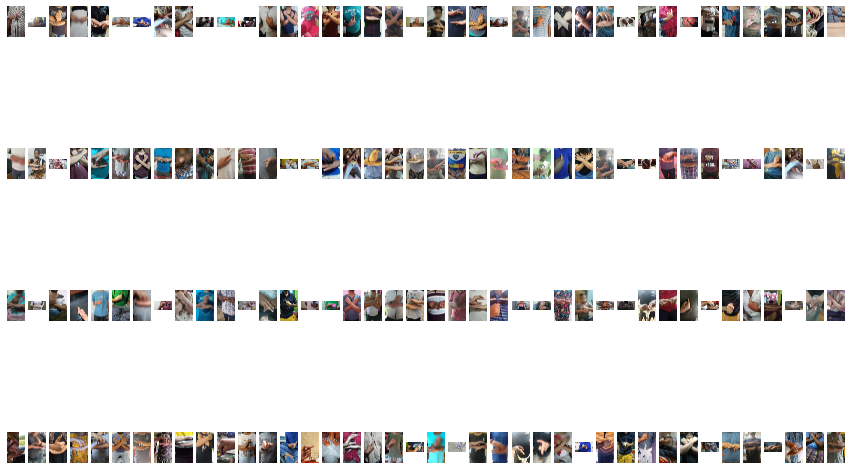

In [7]:
tfms=get_transforms(do_flip=True,
                    flip_vert=True,# flip vertical and horizontal
                    max_lighting=0.3,
                    max_zoom=1.8, # zoom between 1 and 1.8
                    max_warp=0.2,
                    max_rotate=45) # rotate between -45 and 45

# Function that returns an image from its url
def get_img(img_url): return open_image(img_url)


# Function that displays one image after transformations
def display_img_after_tfms(img_url, tfms, ax, label):
        img = get_img(img_url).apply_tfms(tfms=tfms, size=224)
        img.show(ax=ax)
        ax.set_title(x=0.5,y=-0.1, label=label)
        
fig, axs = plt.subplots(4,40,figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    img = get_img(fnames[i])
    img.show(ax=ax)
plt.show()

In [8]:
df = pd.read_csv("../input/kslc-dataset/train.csv")
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [9]:
# Create ImageDataBunch with transformations  
data = ImageDataBunch.from_df(img_path,
                              df,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=2,
                              bs=8,
                             suffix='.jpg').normalize(imagenet_stats)
print(data.c)

9


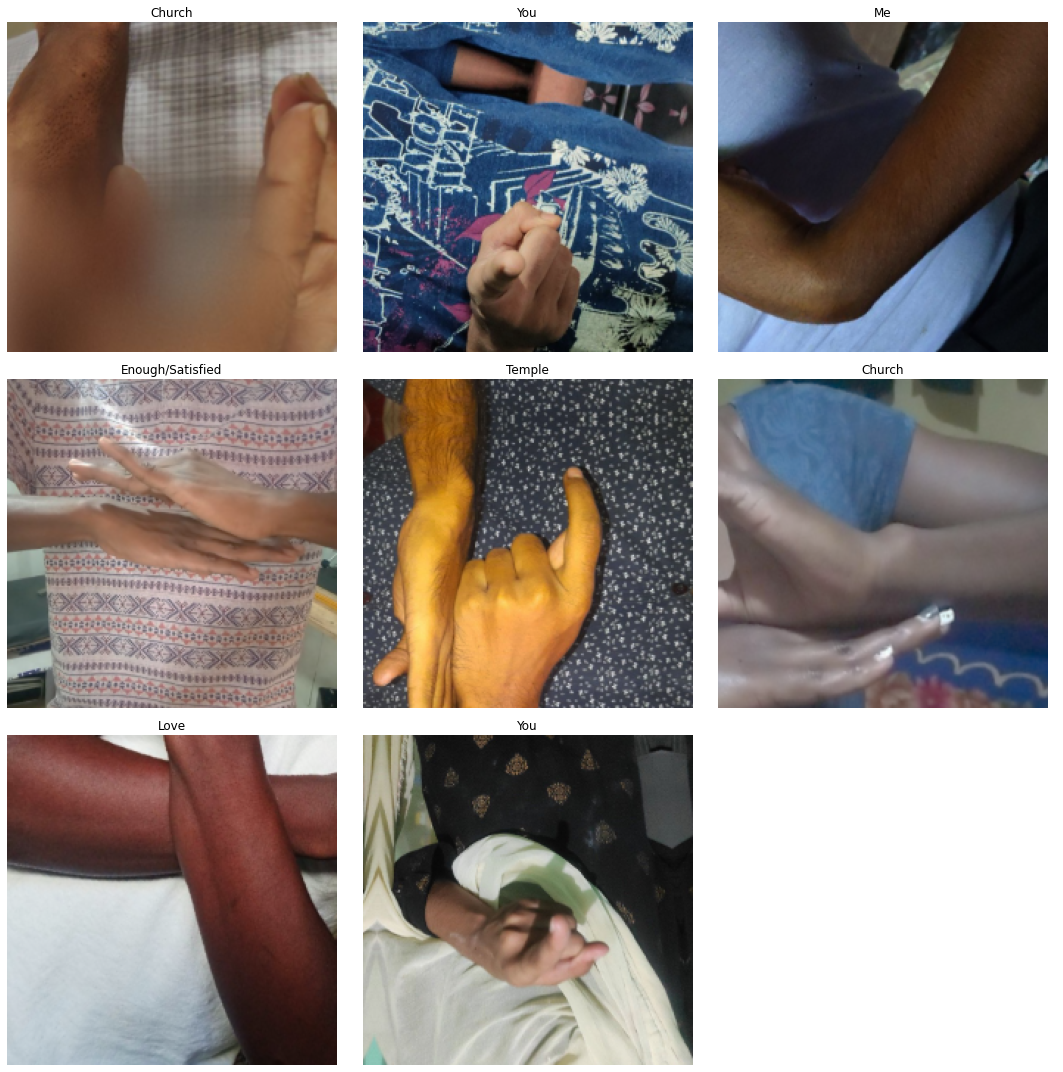

In [10]:
# Look at some examples
data.show_batch(rows=3, figsize=(15, 15)) 

## Baseline
* Using resnet model

In [14]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy])

#Fit
epochs = 1
learn.fit_one_cycle(epochs, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.445700,1.653051,0.567654,0.432346,05:27


## [Learning Rate Finder](https://medium.com/analytics-vidhya/the-learning-rate-finder-9203fdc67c92)
* Hyper-parameter which controls the rate or speed at which the model learns.

## Prediction on Test Set

In [15]:
test = pd.read_csv("/kaggle/input/kslc-dataset/test.csv")
test.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [16]:
test = ImageList.from_df(test, img_path, suffix='.jpg')
data.add_test(test)

In [ ]:
#preds_test,y_test = learn.get_preds(DatasetType.Test)

In [ ]:
#preds_test[:,1]

In [ ]:
#y_test

In [ ]:
#sub=pd.read_csv('/kaggle/input/submission-sample/SampleSubmission.csv')
#print(sub.head())
#k=[]
#for col in sub.columns: 
#    k.append(col) # creating list of the label

In [ ]:
#submission = sub.copy()
#for i, c in enumerate(learn.data.classes):
#    submission[c] = preds_test[:,i]
#submission = submission[k] # Get same order as sample sub
#submission.head()

In [ ]:
# name = "kslc_baseline_1.csv"
# submission.to_csv(name, index=False)

In [ ]:
#submission.to_csv('baline_model.csv', index=False)

## Efficient Model

In [17]:
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import log_loss

def get_model(data,pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model.cpu() # moves the data to CPU. It converts the value into a plain python number 
                       # and plain python number can only live on the CPU.

model_name = 'efficientnet-b5' #I'll use B5 here
modell_name = 'efficientnet-b7'

In [18]:
learn2 = Learner(data, get_model(data), metrics=[error_rate, accuracy],
                 model_dir = "/kaggle/working").to_fp16()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 7.59E-04


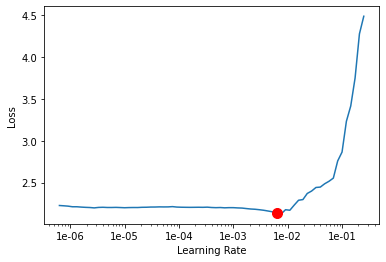

In [19]:
learn2.lr_find()
learn2.recorder.plot(suggestion = True)

In [20]:
epoch = 3

learn2.fit_one_cycle(epoch, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.333449,0.861269,0.249800,0.750200,06:04
1,0.876452,0.465338,0.140112,0.859888,06:04
2,0.837030,0.430995,0.132906,0.867094,06:04


In [ ]:
learn3 = Learner(data, get_model(data), metrics=[error_rate, accuracy, log_loss], callback_fns=ShowGraph,model_dir = "/kaggle/working").to_fp16()
learn3.lr_find()

In [ ]:
learn3.recorder.plot_lr(show_moms = True)

In [ ]:
# Fit
num_epochs = 3
learn3.fit_one_cycle(num_epochs, 1e-4)

In [ ]:
preds_test,y_test = learn2.get_preds(DatasetType.Test)

In [ ]:
preds_test[:,1]

In [ ]:
y_test

In [ ]:
sub=pd.read_csv('/kaggle/input/submission-sample/SampleSubmission.csv')
print(sub.head())
k=[]
for col in sub.columns: 
    k.append(col) # creating list of the label

In [ ]:
submission = sub.copy()
for i, c in enumerate(learn.data.classes):
    submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

In [ ]:
submission.to_csv('efficient_model3.csv', index=False)

In [ ]:
learn4 = cnn_learner(data, models.resnet152, metrics=accuracy, callback_fns=BnFreeze)
learn4.fit_one_cycle(1)

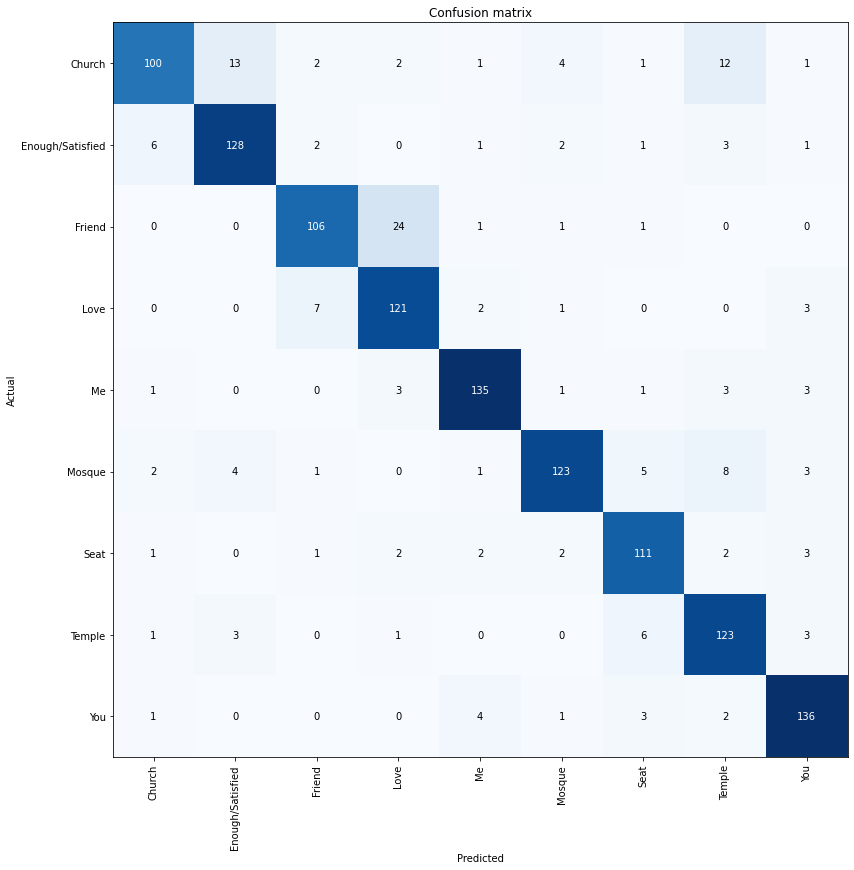

In [29]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix(figsize=(12,12))

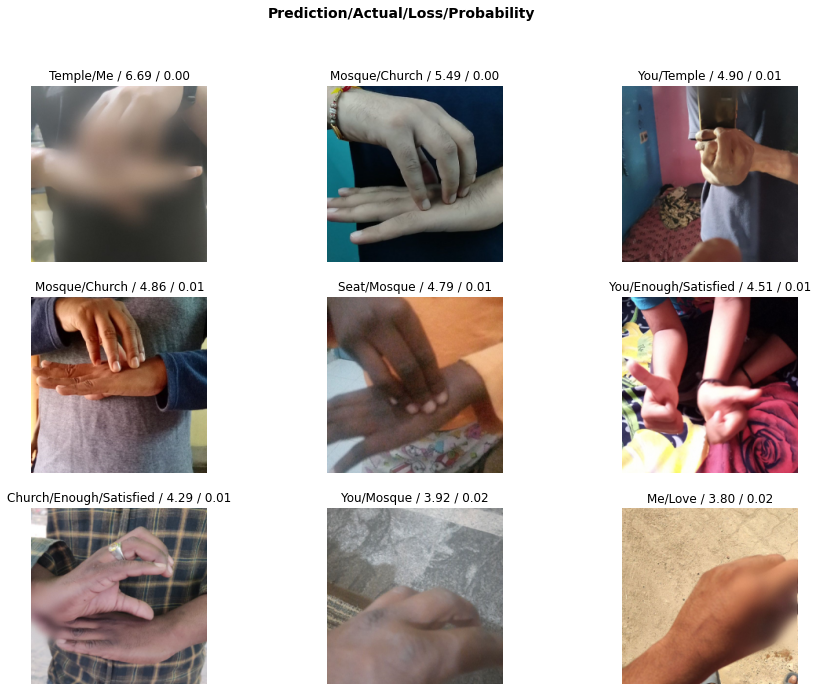

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

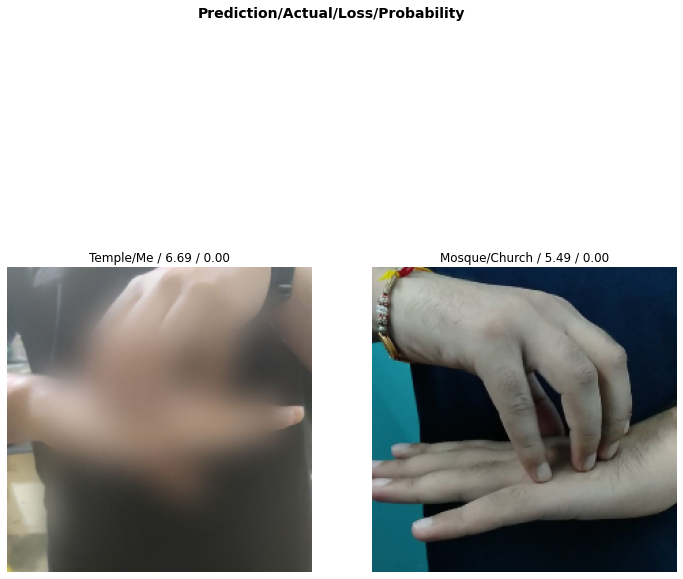

In [32]:
interp.plot_top_losses(2)

In [27]:
interp.confusion_matrix(slice_size=10)

array([[100,  13,   2,   2, ...,   4,   1,  12,   1],
       [  6, 128,   2,   0, ...,   2,   1,   3,   1],
       [  0,   0, 106,  24, ...,   1,   1,   0,   0],
       [  0,   0,   7, 121, ...,   1,   0,   0,   3],
       ...,
       [  2,   4,   1,   0, ..., 123,   5,   8,   3],
       [  1,   0,   1,   2, ...,   2, 111,   2,   3],
       [  1,   3,   0,   1, ...,   0,   6, 123,   3],
       [  1,   0,   0,   0, ...,   1,   3,   2, 136]])

In [33]:
interp.most_confused(min_val=5)

[('Friend', 'Love', 24),
 ('Church', 'Enough/Satisfied', 13),
 ('Church', 'Temple', 12),
 ('Mosque', 'Temple', 8),
 ('Love', 'Friend', 7),
 ('Enough/Satisfied', 'Church', 6),
 ('Temple', 'Seat', 6),
 ('Mosque', 'Seat', 5)]

## TODOs
* Fine tune/ hyperparameters
* Data augmentation